# 공기청정기 과포화 시각화

## 공기청정기 설치 정보 데이터 전처리

In [4]:
import pandas as pd

air_purifier_df = pd.read_csv('서울교통공사_지하역사 승강장 공기청정기 설치 정보_20230320.csv', encoding='euc-kr')

In [17]:
# 데이터 읽기
air_purifier_df = pd.read_csv('서울교통공사_지하역사 승강장 공기청정기 설치 정보_20230320.csv')
predicted_df = pd.read_csv('지하역사_공기질_승하차_정보_예측.csv', encoding='utf-8')

# 1. '역명'과 '설치대수' 열을 제외한 나머지 열 삭제
air_purifier_df = air_purifier_df[['역명', '설치대수']]

# 2. '역명' column에서 소괄호 및 그 안의 내용을 제거
air_purifier_df['역명'] = air_purifier_df['역명'].str.replace(r'\(.*\)', '', regex=True)

# 3. 서울역 -> 서울
air_purifier_df['역명'] = air_purifier_df['역명'].str.replace('서울역', '서울')

# 4. predicted_df의 '역명' column 내에 존재하는 '역명' 값만 남기고 나머지 '역명' 값에 해당하는 row는 삭제
common_stations = predicted_df['역명'].unique()
filtered_air_purifier_df = air_purifier_df[air_purifier_df['역명'].isin(common_stations)]

# 새로운 파일로 저장
filtered_air_purifier_df.to_csv('서울교통공사_지하역사 승강장 공기청정기 설치 정보_20230320.csv', encoding='utf-8-sig')

# 결과 확인
filtered_air_purifier_df

,역명,설치대수
0,서울,16
1,시청,24
2,종각,16
3,동대문,16
4,동묘앞,26
...,...,...
231,남한산성입구,14
232,단대오거리,14
233,신흥,14
234,수진,14


## 군집화에 사용할 데이터 병합

In [25]:
import pandas as pd
from sklearn.cluster import KMeans

# CSV 파일 로드
file_path_1 = '서울교통공사_지하역사 승강장 공기청정기 설치 정보_20230320.csv'
file_path_2 = '지하역사_공기질_승하차_정보_예측.csv'

data_1 = pd.read_csv(file_path_1)
data_2 = pd.read_csv(file_path_2)

# 숫자형으로 변환, 변환 오류 발생 시 NaN 처리 후 0으로 채움
data_2['미세먼지'] = pd.to_numeric(data_2['미세먼지'], errors='coerce').fillna(0)
data_2['총 승객수'] = pd.to_numeric(data_2['총 승객수'], errors='coerce').fillna(0)

# 두 데이터프레임을 '역명' 열을 기준으로 병합
merged_data = pd.merge(data_1, data_2, on='역명')

# PM10 수준에 따른 오염 등급 정의
def classify_pm10_level(pm10):
    if pm10 >= 100:
        return 3  # 기준치 초과
    elif pm10 >= 85:
        return 2  # 위험
    elif pm10 >= 70:
        return 1  # 보통
    else:
        return 0  # 안전

# 오염 등급을 데이터에 적용
merged_data['오염_등급'] = merged_data['미세먼지'].apply(classify_pm10_level)

# PM10과 총 승객수를 고려한 오염 점수 계산
merged_data['오염_점수'] = 0.6 * merged_data['미세먼지'] + 0.4 * (merged_data['총 승객수'] / merged_data['총 승객수'].max() * 100)

# 공기청정기 설치 대수로 군집화 수행
kmeans = KMeans(n_clusters=5, random_state=0)
merged_data['공기청정기_군집'] = kmeans.fit_predict(merged_data[['설치대수']])

# 군집 레이블을 원하는 카테고리로 매핑
cluster_mapping = {0: '심각한 부족', 1: '부족', 2: '적합', 3: '과잉', 4: '심각한 과잉'}
merged_data['공기청정기_효용_상태'] = merged_data['공기청정기_군집'].map(cluster_mapping)

# 파일 저장
merged_data.to_csv('공기청정기_효용상태.csv')

# 결과 출력
print(merged_data[['역명', '미세먼지', '총 승객수', '오염_등급', '오염_점수', '설치대수', '공기청정기_효용_상태']])


      역명   미세먼지     총 승객수  오염_등급      오염_점수  설치대수 공기청정기_효용_상태
0     서울   86.9  137657.0      2  73.313521    16      심각한 부족
1     서울   96.5  137657.0      2  79.073521    16      심각한 부족
2     서울   82.6  194273.0      1  79.441833    16      심각한 부족
3     서울  101.7  194273.0      3  90.901833    16      심각한 부족
4     서울   76.4  210272.0      1  78.182697    16      심각한 부족
...   ..    ...       ...    ...        ...   ...         ...
1964  모란   76.1   54347.0      1  54.019309    16      심각한 부족
1965  모란   51.1   34774.0      0  36.008715    16      심각한 부족
1966  모란   39.8   44452.0      0  30.717323    16      심각한 부족
1967  모란   24.2   36047.0      0  20.064519    16      심각한 부족
1968  모란    0.0       0.0      0   0.000000    16      심각한 부족

[1969 rows x 7 columns]


## 오염점수와 공기청정기 설치 대수를 고려한 k-Mean 군집화

In [26]:
import pandas as pd
from sklearn.cluster import KMeans

# CSV 파일 로드
file_path_1 = '서울교통공사_지하역사 승강장 공기청정기 설치 정보_20230320.csv'
file_path_2 = '지하역사_공기질_승하차_정보_예측.csv'

data_1 = pd.read_csv(file_path_1)
data_2 = pd.read_csv(file_path_2)

# 숫자형으로 변환, 변환 오류 발생 시 NaN 처리 후 0으로 채움
data_2['미세먼지'] = pd.to_numeric(data_2['미세먼지'], errors='coerce').fillna(0)
data_2['총 승객수'] = pd.to_numeric(data_2['총 승객수'], errors='coerce').fillna(0)

# 두 데이터프레임을 '역명' 열을 기준으로 병합
merged_data = pd.merge(data_1, data_2, on='역명')

# '연도' 컬럼 삭제
merged_data = merged_data.drop(columns=['연도'])

# 중복된 '역명'에 대해 첫 번째 행만 남기기
merged_data = merged_data.drop_duplicates(subset=['역명'], keep='first')

# 오염 등급 정의
def classify_pm10_level(pm10):
    if (pm10 >= 100):
        return 3  # 기준치 초과
    elif (pm10 >= 85):
        return 2  # 위험
    elif (pm10 >= 70):
        return 1  # 보통
    else:
        return 0  # 안전

# 오염 등급을 데이터에 적용
merged_data['오염_등급'] = merged_data['미세먼지'].apply(classify_pm10_level)

# PM10과 총 승객수를 고려한 오염 점수 계산
merged_data['오염_점수'] = 0.6 * merged_data['미세먼지'] + 0.4 * (merged_data['총 승객수'] / merged_data['총 승객수'].max() * 100)

# 공기청정기 설치 대수와 오염 점수를 고려한 군집화 수행
kmeans = KMeans(n_clusters=5, random_state=0)
merged_data['공기청정기_군집'] = kmeans.fit_predict(merged_data[['설치대수', '오염_점수']])

# 군집 레이블을 원하는 카테고리로 매핑
cluster_mapping = {0: '심각한 부족', 1: '부족', 2: '적합', 3: '과잉', 4: '심각한 과잉'}
merged_data['공기청정기_효용_상태'] = merged_data['공기청정기_군집'].map(cluster_mapping)

# 결과 출력 및 저장
merged_data.to_csv('공기청정기_효용상태.csv', index=False)
print(merged_data[['역명', '미세먼지', '총 승객수', '오염_등급', '오염_점수', '설치대수', '공기청정기_효용_상태']])


          역명   미세먼지     총 승객수  오염_등급      오염_점수  설치대수 공기청정기_효용_상태
0         서울   86.9  137657.0      2  73.313521    16          적합
12        시청  102.0   58210.0      3  70.153491    24          적합
25        종각   79.4   85411.0      1  60.777375    16      심각한 과잉
32       동대문   89.4   62261.0      2  63.216590    16      심각한 과잉
45       동묘앞   93.6   40550.0      2  62.397142    26          적합
...      ...    ...       ...    ...        ...   ...         ...
1934  남한산성입구   75.1   15118.0      1  47.385354    14          과잉
1941   단대오거리   69.8   13931.0      0  44.022777    14      심각한 부족
1948      신흥   82.1    7802.0      1  50.460054    14          과잉
1955      수진   75.8    8433.0      1  46.777110    14          과잉
1962      모란   77.2   35348.0      1  51.757004    16          과잉

[208 rows x 7 columns]


## 군집화 시각화 -----> scatter plot 색이 이상해요ㅠㅠㅠ 새벽이라 졸려서 원인을 못 찾겠어요ㅠㅠ

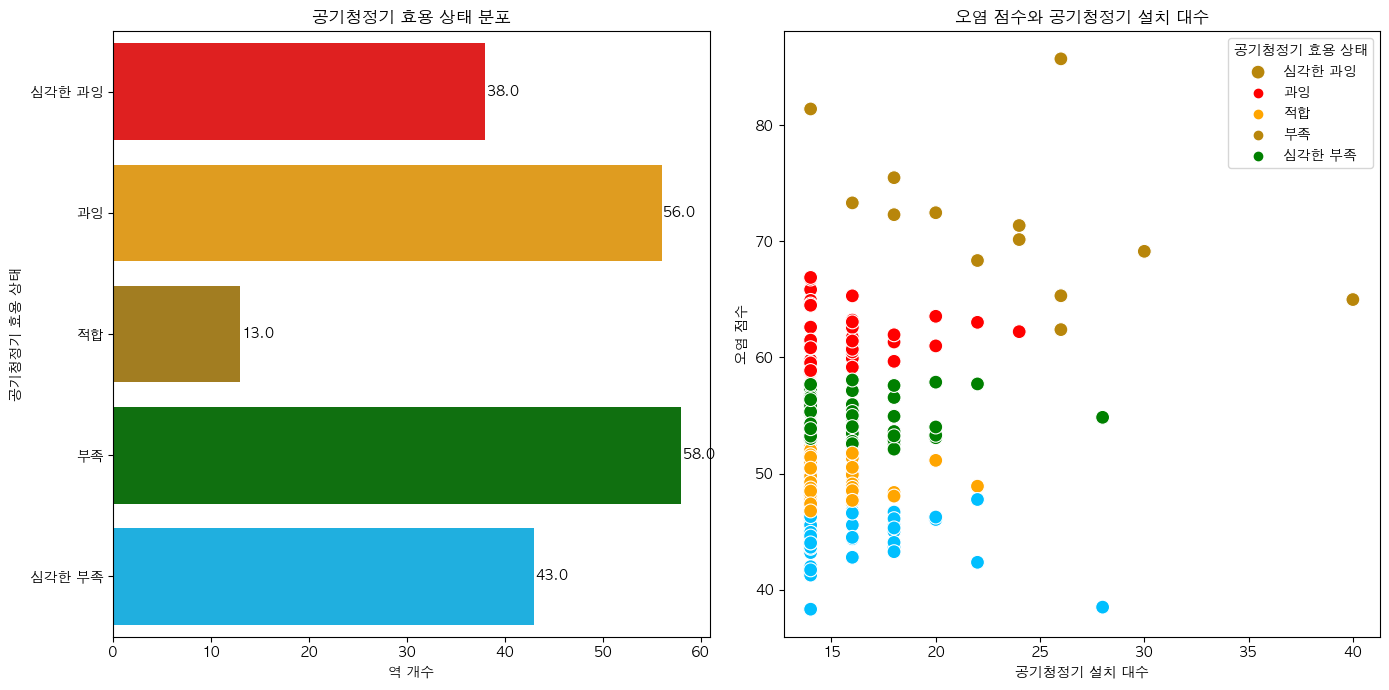

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from matplotlib.colors import ListedColormap

# 한글 폰트 설정
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'  # MacOS
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# '공기청정기_효용상태.csv' 파일 로드
file_path = '공기청정기_효용상태.csv'
data = pd.read_csv(file_path)

# 색상 설정
colors = ["#FF0000", "#FFA500", "#B8860B", "#008000", "#00BFFF"]
hue_order = ['심각한 과잉', '과잉', '적합', '부족', '심각한 부족']
cmap = ListedColormap(colors)

# 시각화
plt.figure(figsize=(14, 7))

# 공기청정기 효용 상태 막대 그래프
plt.subplot(1, 2, 1)
ax = sns.countplot(y='공기청정기_효용_상태', data=data, order=hue_order, palette=colors)
plt.title('공기청정기 효용 상태 분포')
plt.xlabel('역 개수')
plt.ylabel('공기청정기 효용 상태')

# 막대 위에 개수 표시
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width() + 0.1, p.get_y() + p.get_height() / 2), va='center')

# 오염 점수와 공기청정기 설치 대수 산점도
plt.subplot(1, 2, 2)
sns.scatterplot(x='설치대수', y='오염_점수', hue='공기청정기_효용_상태', data=data, palette=colors, s=100, hue_order=hue_order)

plt.title('오염 점수와 공기청정기 설치 대수')
plt.xlabel('공기청정기 설치 대수')
plt.ylabel('오염 점수')

# Legend 설정
plt.legend(title='공기청정기 효용 상태', loc='upper right', labels=hue_order)

plt.tight_layout()
plt.show()
